<a href="https://colab.research.google.com/github/roshanappa/AutoEncoder/blob/main/Autoencoder_In_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

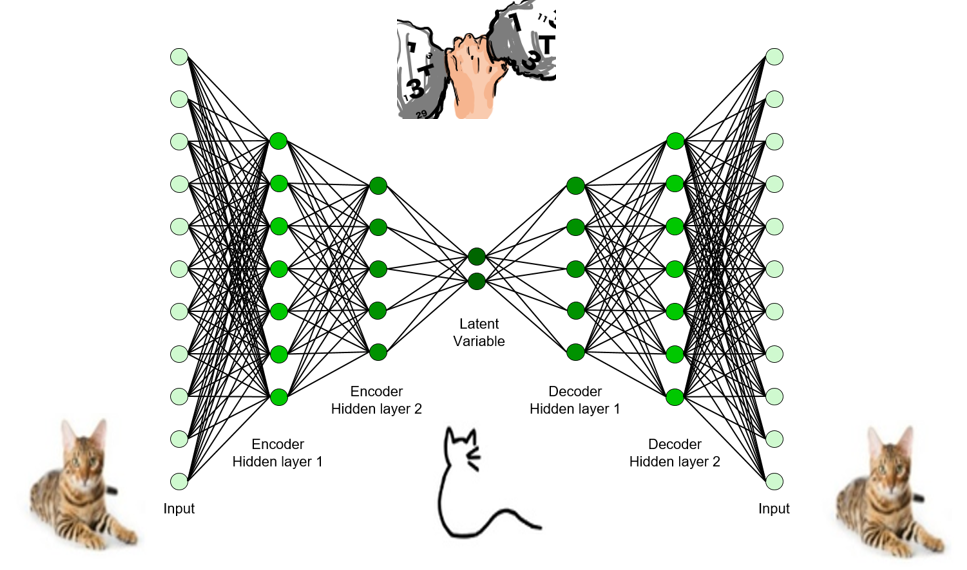


Unsupervised Learning with Auto-Encoders
If you are interested in an introduction to auto-encoders, head over to Julien Despois' article. If a more technical breakdown is what you are looking for, check out Lilian Weng's blog post from which the below image is sourced. It illustrates the functioning of an auto-encoder for MNIST images, but the concept is the same.

The idea is quite straightforward:

Due to the bottleneck architecture of the neural network, it is forced to learn a condensed representation from which to reproduce the original input.
We feed it only normal transactions, which it will learn to reproduce with high fidelity.
As a consequence, if a fraud transaction is sufficiently distinct from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent reconstruction loss will be high.
Anything above a specific loss (threshold) will be flagged as anomalous and thus labeled as fraud.


In [141]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Input,Dense,RepeatVector,TimeDistributed
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Model
import seaborn as sns

In [142]:
df = pd.read_csv('/content/GE.csv')

In [143]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,27/09/2016,227.692307,230.538467,226.692307,229.846161,212.185547,3313947
1,28/09/2016,230.153839,230.307693,227.692307,230.000000,212.327576,3477578
2,29/09/2016,229.307693,231.538467,226.461533,227.153839,209.700119,5053581
3,30/09/2016,227.692307,229.615387,227.538467,227.846161,210.339188,4695600
4,03/10/2016,226.615387,228.461533,226.153839,228.000000,210.481277,2573233


In [144]:
data = df[['Date','Close']]

In [145]:
data.head()

,Date,Close
0,27/09/2016,229.846161
1,28/09/2016,230.000000
2,29/09/2016,227.153839
3,30/09/2016,227.846161
4,03/10/2016,228.000000


In [146]:
data.dtypes

Date      object
Close    float64
dtype: object

In [147]:
data['Date']=pd.to_datetime(data['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
data.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [149]:
np.max(data['Date'])

Timestamp('2021-12-08 00:00:00')

In [150]:
np.min(data['Date'])

Timestamp('2016-01-11 00:00:00')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


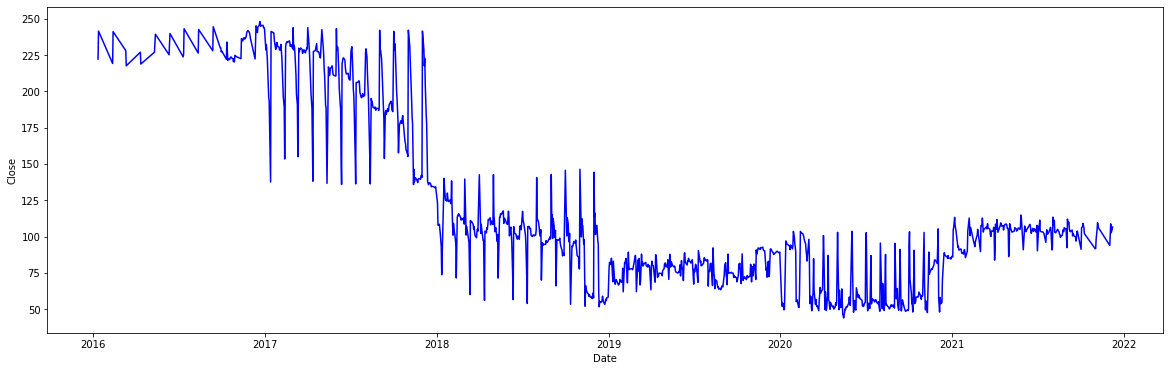

In [151]:
plt.figure(figsize=(20,6))
sns.lineplot(data['Date'],data['Close'],color='b')
plt.show()

In [152]:
data.set_index(data['Date'],drop=True)

,Date,Close
Date,,
2016-09-27,2016-09-27,229.846161
2016-09-28,2016-09-28,230.000000
2016-09-29,2016-09-29,227.153839
2016-09-30,2016-09-30,227.846161
2016-03-10,2016-03-10,228.000000
...,...,...
2021-09-20,2021-09-20,99.809998
2021-09-21,2021-09-21,96.820000
2021-09-22,2021-09-22,98.540001


In [153]:
train_data = data.loc[data['Date']>='2019-01-01']
test_data  = data.loc[data['Date']<'2019-01-01']

In [154]:
train_data.shape,test_data.shape

((689, 2), (569, 2))

In [155]:
scaler = StandardScaler()
train_data['Close'] = scaler.fit_transform(train_data[['Close']])
test_data['Close'] = scaler.fit_transform(test_data[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
seq_size=30

def to_sequence(x,y,seq_size=1):
  x_values =[]
  y_values =[]

  for i in range(len(x)-seq_size):   #it start with 689-30 =659
    #print(i)
    x_values.append(x.iloc[i:(i+seq_size)])
    y_values.append(y.iloc[i+seq_size])
  

  return np.array(x_values),np.array(y_values)

In this kind of function we have use the sequence size is equal to 30 and then 

- For x_values append we have use the i =0 and i+30 means =30. Here 0 to 30.
- For y_values append we have used the 31.

In [157]:
train_x,train_y = to_sequence(train_data[['Close']],train_data['Close'],seq_size)
test_x,test_y = to_sequence(test_data[['Close']],test_data['Close'],seq_size)

In [158]:
train_x.shape,train_y.shape

((659, 30, 1), (659,))

In [159]:
test_x.shape,test_y.shape

((539, 30, 1), (539,))

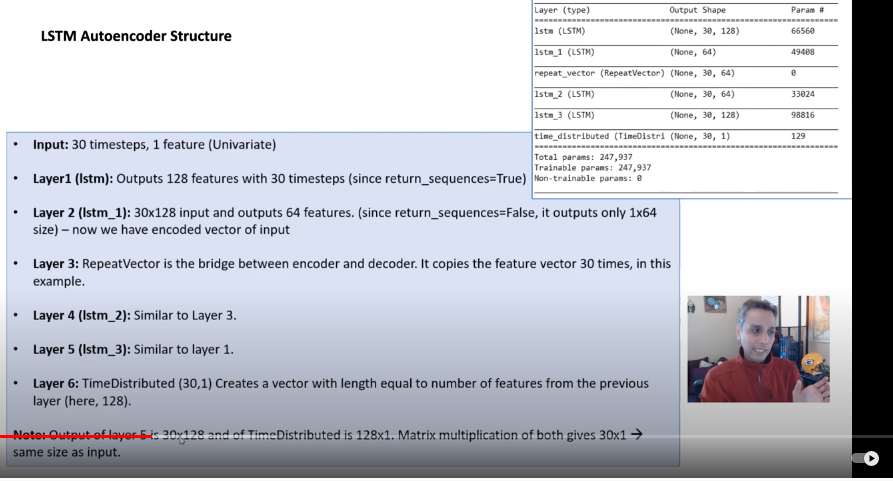

In [160]:
model = Sequential()
model.add(LSTM(128,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(train_x.shape[1]))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(train_x.shape[2])))

model.compile(optimizer='adam',loss='mae')

In [161]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [162]:
history = model.fit(train_x,train_y,epochs=10,batch_size=32,validation_split=0.1,verbose=1)

Epoch 1/10
19/19 [==============================] - 5s 104ms/step - loss: 0.3554 - val_loss: 0.2230
Epoch 2/10
19/19 [==============================] - 1s 67ms/step - loss: 0.1945 - val_loss: 0.2034
Epoch 3/10
19/19 [==============================] - 1s 66ms/step - loss: 0.1673 - val_loss: 0.1395
Epoch 4/10
19/19 [==============================] - 1s 66ms/step - loss: 0.1483 - val_loss: 0.1327
Epoch 5/10
19/19 [==============================] - 1s 66ms/step - loss: 0.1481 - val_loss: 0.1671
Epoch 6/10
19/19 [==============================] - 1s 65ms/step - loss: 0.1413 - val_loss: 0.1221
Epoch 7/10
19/19 [==============================] - 1s 68ms/step - loss: 0.1361 - val_loss: 0.1192
Epoch 8/10
19/19 [==============================] - 1s 68ms/step - loss: 0.1439 - val_loss: 0.1158
Epoch 9/10
19/19 [==============================] - 1s 66ms/step - loss: 0.1398 - val_loss: 0.1644
Epoch 10/10
19/19 [==============================] - 1s 67ms/step - loss: 0.1370 - val_loss: 0.1215


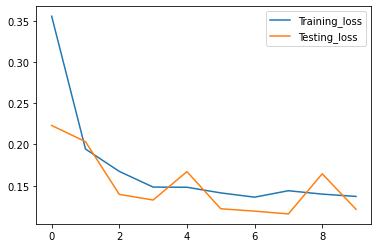

In [163]:
plt.plot(history.history['loss'],label='Training_loss')
plt.plot(history.history['val_loss'],label='Testing_loss')
plt.legend()
plt.show()

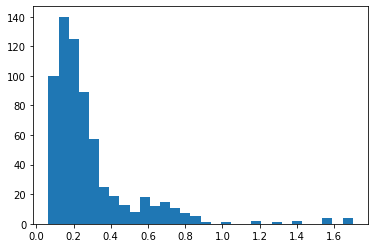

In [164]:
train_predict = model.predict(train_x)
train_MAE = np.mean(np.abs(train_predict-train_x),axis=1)
plt.hist(train_MAE,bins=30)
plt.show()

By looking this graph we are going to decide the threshold that is 0.5.

In [165]:
max_TrainMAE = 0.3

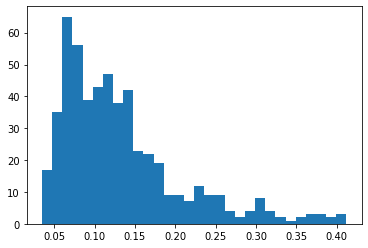

In [166]:
test_predict = model.predict(test_x)
test_MAE = np.mean(np.abs(test_predict-test_x),axis=1)
plt.hist(test_MAE,bins=30)
plt.show()

In [167]:
max_TestMAE = 0.15

In [168]:
Anomaly_df = pd.DataFrame(test_data[seq_size:])
Anomaly_df['testMAE']=test_MAE
Anomaly_df['max_trainMAE']=max_TrainMAE
Anomaly_df['max_testMAE']=max_TestMAE
Anomaly_df['Anomaly']=Anomaly_df['testMAE']>Anomaly_df['max_trainMAE']
Anomaly_df['Close']=test_data[seq_size:]['Close']

In [169]:
Anomaies=Anomaly_df[Anomaly_df['Anomaly']==True]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


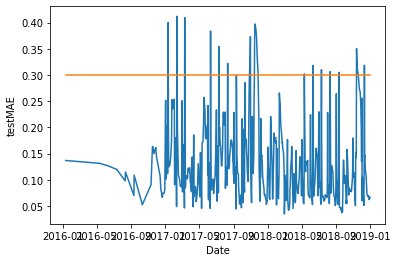

In [170]:
sns.lineplot(Anomaly_df['Date'],Anomaly_df['testMAE'])
sns.lineplot(Anomaly_df['Date'],Anomaly_df['max_trainMAE'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


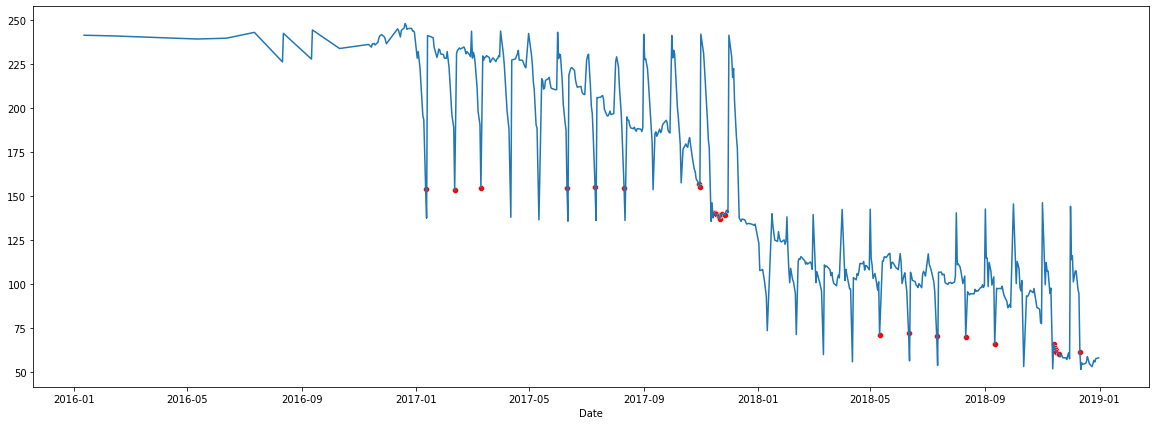

In [172]:
plt.figure(figsize=(20,7))
sns.lineplot(Anomaly_df['Date'],scaler.inverse_transform(Anomaly_df['Close']))
sns.scatterplot(Anomaies['Date'],scaler.inverse_transform(Anomaies['Close']),color='r',marker='o')
plt.show()

## Thank You !!
